# 特斯拉

 ## 前處理
 資料來源 : ptt(跟憲聰一樣  
+ 資料來源 : PPT車版
+ 關鍵字 : 特斯拉、Tesla
+ 停用字 : 馬斯克、Musk
+ 訓練資料日期 : 2023/1/1 - 2024/4/30


In [31]:
import time 
import pandas as pd #pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
import numpy as np #numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
import re #re: 正規表達式套件。
import math #math: 數學運算工具。
import datetime
from pprint import pprint

import seaborn as sns
from matplotlib import font_manager
import matplotlib.pyplot as plt  #matplotlib: 繪圖工具。

import jieba #jieba: 中文斷詞套件。
import jieba.analyse

import pyLDAvis
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import guidedlda

from wordcloud import WordCloud 
from nltk import ngrams, FreqDist #NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
from collections import Counter, namedtuple #collections: 提供額外的數據類型。
import networkx as nx #networkx: 網絡圖建構、繪製工具。
from snownlp import SnowNLP #SnowNLP 針對中文設計，可以提取句子的情緒分類
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer #CountVectorizer, TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import json
import os
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [32]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['jf-openhuninn-2.0'] #金萱粉圓體2.0
# plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] 

# 設定文字雲中文字體路徑 金萱粉圓體2.0
FontPath = 'font/jf-openhuninn-2.0.ttf' # 設定字型
# FontPath = './SourceHanSansTW-Regular.otf' # 設定字型

plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

# Path to the custom font
font_path = 'font/jf-openhuninn-2.0.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break


Found font: jf-openhuninn-2.0


In [33]:
#匯入資料
df = pd.read_csv('./data/ppt_tesla.csv', encoding = 'UTF-8')
df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
# df = df[['artDate','artTitle','artContent']]
df['artDate'] = pd.to_datetime(df['artDate'])
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01 10:48:19,xross,car,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""maniaque"", ""...",99.36.164.58,2023-01-02 01:04:34,ptt
1,2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01 22:42:25,jpopo0543,car,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""r7698"", ""cmt...",114.46.142.179,2023-01-02 01:04:40,ptt
2,3,https://www.ptt.cc/bbs/car/M.1672634853.A.527....,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,2023-01-02 12:47:31,weiflower520,car,原文連結：\nhttps://star.setn.com/news/1232578?utm_...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""tyrande"", ""c...",27.247.164.57,2023-01-03 01:04:36,ptt


In [34]:
# 將 artDate 欄位轉換為日期格式，只保留日期部分
df['artDate'] = pd.to_datetime(df['artDate']).dt.date

# 計算最小日期和最大日期
min_date = df['artDate'].min()
max_date = df['artDate'].max()

print("最小日期:", min_date)
print("最大日期:", max_date)

最小日期: 2023-01-01
最大日期: 2024-04-30


將comment也放入到content中

In [35]:
# # 定義一個函數來提取評論內容並連接到文章內容
# def append_comments(row):
#     comments = json.loads(row['artComment'])
#     comments_content = ' '.join([comment['cmtContent'] for comment in comments])
#     return row['artContent'] + ' ' + comments_content

# # 應用該函數並創建新的artContent列
# df['artContent'] = df.apply(append_comments, axis=1)
# df

In [36]:
MetaData_sentence = df.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 去除na值
MetaData_sentence.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

# 只留下中文字
MetaData_sentence['sentence'] = MetaData_sentence['artContent'].str.replace(r'\n\n','。', regex=True)
MetaData_sentence['sentence'] = MetaData_sentence['sentence'].str.replace(r'\n','', regex=True)

MetaData_sentence['sentence'] = MetaData_sentence['sentence'].str.split("[,，。！!？?]{1,}")
MetaData_sentence = MetaData_sentence.explode('sentence').reset_index(drop=True)
MetaData_sentence['sentence'] = MetaData_sentence['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))
MetaData_sentence = MetaData_sentence[MetaData_sentence["sentence"].str.len() > 1]
MetaData_sentence

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,八卦是官網特斯拉二手車
1,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,比很多第三方平台都便宜
2,1,https://www.ptt.cc/bbs/car/M.1672541301.A.6ED....,Re:[情報]慟！特斯拉二手價跌好多,2023-01-01,八卦是官網特斯拉二手車\n\n比很多第三方平台都便宜\nhttps://www.tesla....,等等黨會勝利嗎
4,2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,各位前輩好想買中古特斯拉里程約萬上下的
5,2,https://www.ptt.cc/bbs/car/M.1672584147.A.632....,[問題]特斯拉久了會掉電嗎？,2023-01-01,各位前輩好\n 想買中古特斯拉\n里程約5萬上下的\n\n擔心電池久了會掉電\n越充越少電 ...,擔心電池久了會掉電越充越少電里程數越少開了年後車子變成垃圾里程連公里都不到
...,...,...,...,...,...,...
46220,1585,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,爬文版上好像有更優惠的菜單
46221,1585,https://www.ptt.cc/bbs/car/M.1714476000.A.BE6....,[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,最近物色下一台車\n\n原本抓250左右\n\n上週去看了特斯拉 MODEL Y LONG ...,請問我的用車情境有更好的選擇嗎
46223,1586,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,吧你家裡沒有充電樁工作地點也沒有每年里程數不夠高沒必要買
46224,1586,https://www.ptt.cc/bbs/car/M.1714478010.A.4C6....,Re:[問題]TESLAMODELYVSLEXUSRX350FSPORT,2024-04-30,RX吧\n你家裡沒有充電樁工作地點也沒有\n每年里程數不夠高\n沒必要買Y LR\n\n不過...,不過你預算到有喜歡飆車的話


In [37]:
MetaData = df.copy()
# 去除na值
MetaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
# 移除網址格式
MetaData["artContent"] = MetaData["artContent"].str.replace("(http|https)://.*", "", regex=True)
# 置換換行符號
MetaData['artContent'] = MetaData['artContent'].str.replace(r'\n\n','。', regex=True)
MetaData['artContent'] = MetaData['artContent'].str.replace(r'\n','', regex=True)
MetaData['artContent'] = MetaData['artContent'].str.replace(r'\n\n\n','', regex=True)
#去除句子中除了字母、中文和空格以外的符號
# MetaData['artContent'] = MetaData['artContent'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)
# MetaData['artContent'] = MetaData['artContent'].str.replace(r'[^a-zA-Z\s]+', '', regex=True).astype(str)
MetaData['artContent'] = MetaData['artContent'].str.replace(r'[^a-zA-Z\u4e00-\u9fff\s]+', '', regex=True)
# 統一把英文變小寫
MetaData['artContent'] = MetaData['artContent'].str.lower()
# # 只留下中文字
# MetaData["artContent"] = MetaData["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
# MetaData["artTitle"] = MetaData["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
MetaData['content'] = MetaData['artContent']
# 調整時間格式
# # 將 artDate 轉換為日期時間格式
# MetaData['artDate'] = pd.to_datetime(MetaData['artDate'])
# # 提取日期部分並覆寫原始欄位
# MetaData['artDate'] = MetaData['artDate'].dt.date

MetaData = MetaData.loc[:,["artTitle","content"]]
MetaData.reset_index(drop=True, inplace=True)
MetaData

,artTitle,content
0,Re:[情報]慟！特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎
1,[問題]特斯拉久了會掉電嗎？,各位前輩好 想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電 里程數越少開了年後車子...
2,[新聞]開特斯拉「滑手機」被勸Toyz嗆網友有毛,原文連結inpagefbclidiwarouxxhxajrtngqmbwtetyedczeu...
3,[討論]是不是真的有些四輪覺得自己是大爺？,如題 本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道...
4,[新聞]2022美國汽車召回排名揭曉第一名超過8,原文連結原文內容 美國汽車召回排名揭曉 第一名超過 萬輛車進廠處理 結束迎來 許多 年的...
...,...,...
1580,Re:[新聞]特斯拉「全新入門電動車」準備量產！80,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...
1581,Re:[分享]TucsonL撞緩撞車啦,要系統性的改善緩撞車被acc撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠a...
1582,Re:[新聞]銷售降溫賓士上季獲利銳減逾三成、福斯,都轉單到特斯拉了 誰跟你買雙b不針對id本板及m有多位朋友同想法都了還在特斯拉搶走雙b客群就...
1583,[問題]TESLAMODELYVSLEXUSRX350FSPORT,最近物色下一台車原本抓左右上週去看了特斯拉 model y long range這周去看了 ...


In [38]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
jieba.load_userdict('dict/user_dict.txt')
# 新增stopwords
with open('./dict/stop_words.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙
    return seg_list

Building prefix dict from /Users/tsaipingyu/Library/CloudStorage/GoogleDrive-jerryone888@gmail.com/其他電腦/我的筆記型電腦/中山課程_研究所/碩一下/社媒/期末報告/SMA_project_main/蔡秉祐/dict/dict.txt.big ...
Loading model from cache /var/folders/4p/hs58l6r50xd2hy79hrrr3df80000gn/T/jieba.u43f806e834677710d9070e17146f1471.cache
Loading model cost 0.399 seconds.
Prefix dict has been built successfully.


In [39]:
freq_df=MetaData.copy()
# 斷詞、去除停用字並將word欄位展開
freq_df['word'] = freq_df.content.apply(getToken).explode('word')

freq_df = pd.DataFrame(pd.value_counts(freq_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

,word,count
0,特斯拉,39
1,充電,21
2,model,18
3,電動車,13
4,召回,12
5,里程,12
6,汽車,11
7,交付,11
8,生產,10
9,toyota,10


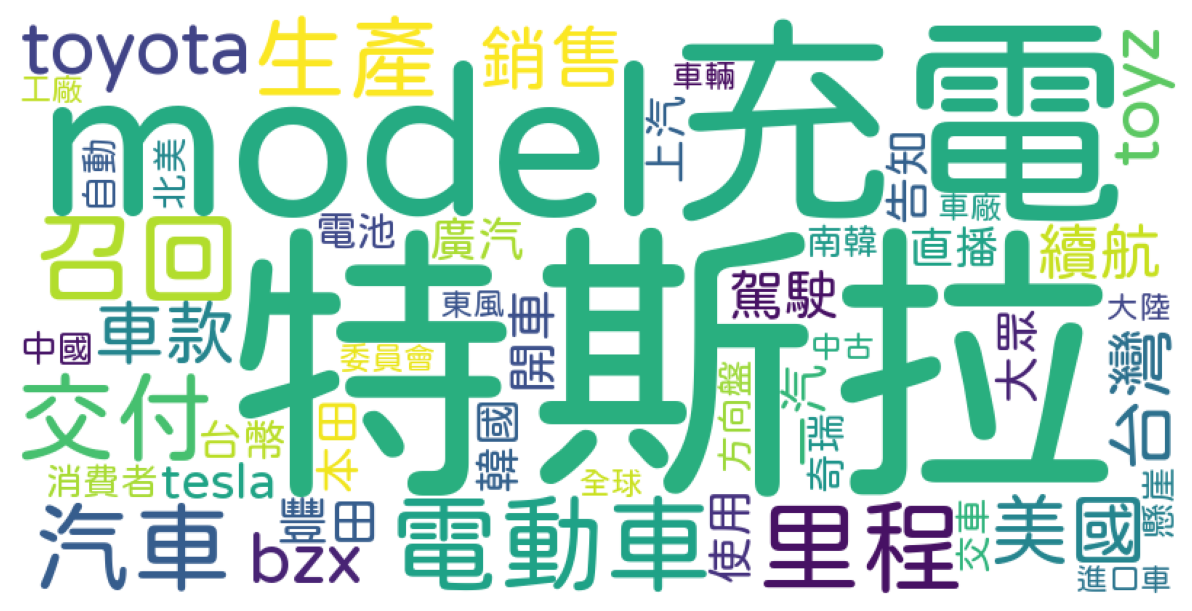

In [40]:
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400,font_path=font_path, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/


# 設定文字雲中文字體路徑

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## bertTopic


In [41]:
from openai import OpenAI
from sentence_transformers import SentenceTransformer, models, util
import os

以下使用 BERTopic 來實作 BERT-based 的 Text Clustering，並介紹 clustering-based 的主題模型<br>
BERTopic: https://maartengr.github.io/BERTopic/index.html<br>
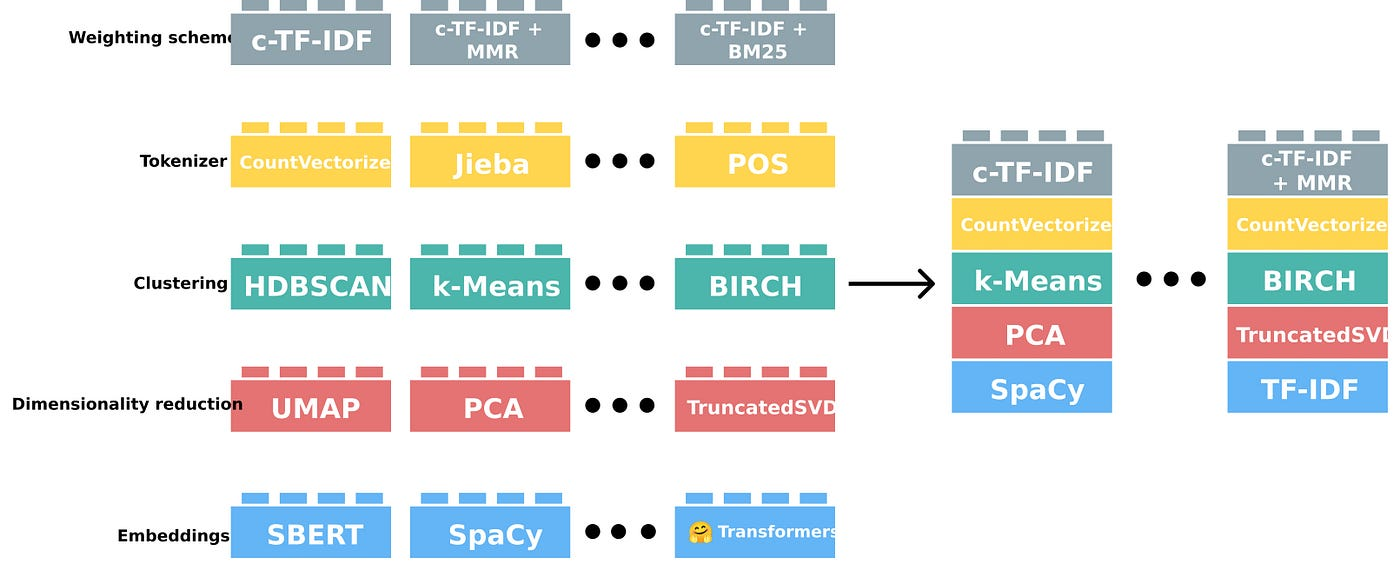

設定中文vectorizer

In [42]:
# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopWords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

設定中文embedding

In [43]:
import pickle
# 从文件读取
with open('embeddings.pkl', 'rb') as file:
    embeddings = pickle.load(file)

def get_shape(lst):
    if isinstance(lst, list):
        return [len(lst)] + get_shape(lst[0])
    else:
        return []
shape = get_shape(embeddings)
# print(shape)  # 输出: [500, 1536]

In [44]:
# docs_zh = MetaData_sentence['sentence'].tolist()[:500]
# client = OpenAI(
#     api_key=os.environ.get("OPENAI_API_KEY")
# )

# def get_embedding_openai(text, model):
#    return client.embeddings.create(input = [text], model=model).data[0].embedding

# embeddings = [get_embedding_openai(word, model="text-embedding-3-small") for word in docs_zh]
# # 3m42.7s

In [101]:
import numpy as np
import openai
from bertopic.backend import OpenAIBackend
# 中文文章
docs_zh = MetaData_sentence['sentence'].tolist()[:500]
# 将嵌入列表转换为 NumPy 数组
embeddings_array = np.array(embeddings)
# 也可以使用 OpenAI API 來獲取性能更強大的語言模型作為 embedding_model
client = openai.OpenAI(api_key="...")

openai_embedding_model = OpenAIBackend(client, "text-embedding-3-small")

# 定義不同 layer 所要使用的模型與方法
hdbscan_model = HDBSCAN()

seed_topic_list = [
    ["服務", "員工", "品質", "後勤", "更換", "速度","態度"],
    ["設備", "交付", "延遲", "據點","原廠"],
    ["價格","優惠","打折","折價"],
    ["安全", "過熱", "火車", "爆炸", "失控","召回","系統","自駕","煞車"],
    ["體驗", "駕駛", "操控", "公差","里程","續航力","加速","噪音","焦慮"],
]

# 將 BERTopic 的 embedding_model 替換為其他模型（openai_embedding_model）
openai_topic_model = BERTopic(embedding_model=openai_embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=jieba_vectorizer,seed_topic_list=seed_topic_list)
topics, probs = openai_topic_model.fit_transform(docs_zh,embeddings_array)

In [102]:
openai_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,131,-1_ _年_輛_特斯拉,"[ , 年, 輛, 特斯拉, 台灣, 交付, 大陸, 幅度, 里程, 這是]","[輛交付, 擔心電池久了會掉電越充越少電里程數越少開了年後車子變成垃圾里程連公里都不到, 特..."
1,0,41,0_降價_南韓_韓國_消費者,"[降價, 南韓, 韓國, 消費者, 委員會, 大陸, 日本, , 台幣, 自然]","[近來日本南韓同樣都有降價動作, 不僅在大陸市場大降價, 二二一年南韓消費者保護團體公民團結..."
2,1,31,1_國道_服務區_車位_充站,"[國道, 服務區, 車位, 充站, 充電站, 站, 充電, 休息, 第三期, 快充]","[國道服務區電動車充電站設置要點, 高公局規劃年前於國道沿線所有服務區要設置共個電動車充電車..."
3,2,29,2_充電_樁_設備_使用,"[充電, 樁, 設備, 使用, 負面影響, 兩次, 每天, 產生, 直流, 至少]","[充電樁設置規格充電設備最低輸出功率需為以上充電樁, 且每天使用兩次以上的直流充電也會對充電..."
4,3,28,3_方向盤_開車_機車_駕車,"[方向盤, 開車, 機車, 駕車, 雙手, 危險, 自動, 手, 離開, 放開]","[但雙手卻完全離開方向盤, 甚至未握方向盤的部分屬於危險駕車, 雙手離開方向盤還開始滑手機]"
5,4,18,4_里程_續航_華氏度_溫度,"[里程, 續航, 華氏度, 溫度, 天氣, 車款, 續航力, 電動車, 降, 低溫]","[前驅車款的續航里程為英里約公里四驅車款則為英里約公里, 多數電動車的里程數在電池需要加熱的..."
6,5,17,5_人民幣_新_台幣_約,"[人民幣, 新, 台幣, 約, 萬, 折合, 新台幣, 售價, 版, 降幅]","[降幅分別為人民幣萬元約新台幣萬元與人民幣萬元約新台幣萬元, 降幅分別為人民幣萬元約新台幣萬..."
7,6,17,6_北美_意見_標點符號_含,"[北美, 意見, 標點符號, 含, 官, 字, 整理, 接單, 打算, 強勢]","[北美在官網上表示, 特粉不意外原文及網址連結心得或意見字不含標點符號, 難怪一接單就直接完..."
8,7,16,7_特斯拉_跳水_降價_品質,"[特斯拉, 跳水, 降價, 品質, 美國, 年交車, 受此, 三流, 供不應求, 一對]","[由上海超級工廠製造的特斯拉跳水大降價, 特斯拉跳水大降價, 而特斯拉經過這次跳水大降價後]"
9,8,15,8_留言_翻_罵_館長,"[留言, 翻, 罵, 館長, 網友, 風波, 震撼, 吼母, 檢舉, 大量]","[甚至還被人爆料詐賭, 網友留言罵翻, 遭大量網友留言罵翻]"


In [103]:
openai_topic_model.visualize_topics()

In [104]:
openai_topic_model.reduce_topics(docs_zh, nr_topics=6)
topics = openai_topic_model.topics_

In [105]:
openai_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,131,-1_ _特斯拉_年_輛,"[ , 特斯拉, 年, 輛, 台灣, 交付, 大陸, 幅度, 約, 里程]","[輛交付, 擔心電池久了會掉電越充越少電里程數越少開了年後車子變成垃圾里程連公里都不到, 特..."
1,0,145,0_充電_ _電動車_國道,"[充電, , 電動車, 國道, 召回, 服務區, 車位, 里程, 設備, 充站]","[充電樁充電時間為促進服務區充電車位使用周轉率, 可能會無法充電, 可能會無法充電]"
2,1,97,1_ _台幣_約_降價,"[ , 台幣, 約, 降價, 人民幣, 新, 銷售, 銷量, 澳洲, 萬]","[降幅分別為人民幣萬元約新台幣萬元人民幣萬元約新台幣萬元以及人民幣萬元約新台幣萬元, 調整過..."
3,2,88,2_ _生產_標案_最後,"[ , 生產, 標案, 最後, 招標, 階段, 一點, 北美, 第三期, 意見]","[新款和共計生產, 而即將於三月招標的第三期標案, 最後一波的第三期標案預計三月進入招標階段]"
4,3,29,3_特斯拉_ _跳水_美國,"[特斯拉, , 跳水, 美國, 純電休, 降價, 再創新高, 公開, 官方, 駕駛]","[由上海超級工廠製造的特斯拉跳水大降價, 特斯拉只有次, 特斯拉跳水大降價]"
5,4,10,4_字_ _還沒_銷售量,"[字, , 還沒, 銷售量, 整個, 感想, 天窗, 全景, 世界, 不見]","[心得說明字以上, 心得說明字以上, 心得說明字以上]"


In [108]:
openai_topic_model.visualize_topics()

In [109]:
topic_distr, _ = openai_topic_model.approximate_distribution(docs_zh)

In [116]:
openai_topic_model.visualize_distribution(topic_distr[-1])

In [111]:
openai_topic_model.get_topic(2)

[(' ', 0.18062097899829863),
 ('生產', 0.08059794240460189),
 ('標案', 0.05400454533885317),
 ('最後', 0.05400454533885317),
 ('招標', 0.050136714404968905),
 ('階段', 0.044924676920855),
 ('一點', 0.04050340900413987),
 ('北美', 0.03893015034179051),
 ('第三期', 0.037602535803726675),
 ('意見', 0.03229590519737491)]

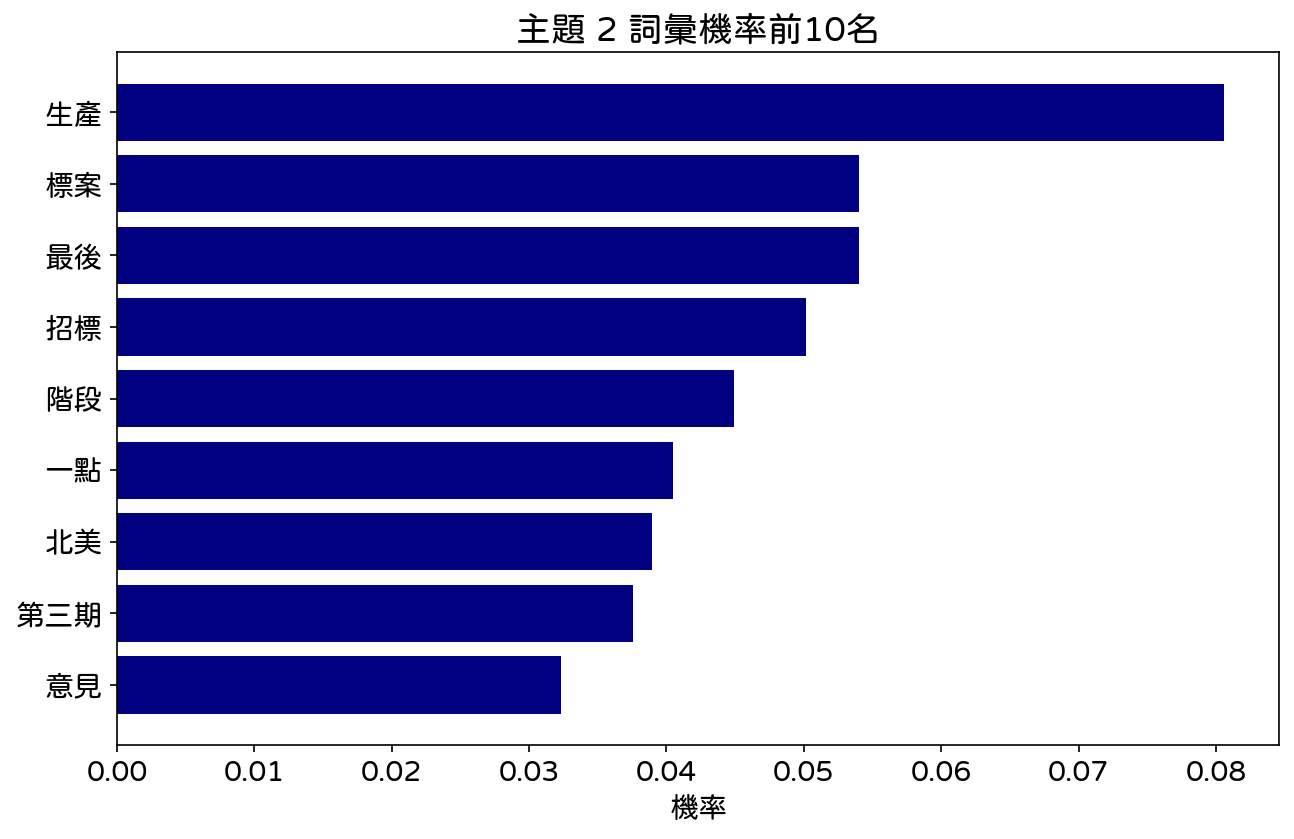

In [113]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = openai_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

## 分群分析
想法 : 用openai embedding model進行embedding，然後進行分群  
用guidedlda進行車種討論

In [ ]:
from collections import defaultdict

In [ ]:
embedding_df=MetaData.copy()
embedding_df['words']=embedding_df.content.apply(getToken)
embedding_df

將每個字放入embedding model

## openai embedding model

In [ ]:
from openai import OpenAI
from sentence_transformers import SentenceTransformer, models, util
import os


In [ ]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

In [ ]:
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

def get_embedding_openai(text, model):
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [ ]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

測試成功，現在來使用我們的word_df

In [ ]:
word_list=embedding_df['words'].explode('word').tolist()
word_unique_list=list(set(word_list))
word_unique_list = [x for x in word_unique_list if not (isinstance(x, float) and math.isnan(x))]
len(word_unique_list)

字太多，用tfidf決定要篩選哪些字詞

In [ ]:
food_df = MetaData.copy()
# 改成使用空格連接斷完的詞
food_df['word'] = food_df.content.apply(getToken).map(' '.join)

food_df.head()

In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(food_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [ ]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [ ]:
tfidf_top_df=(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False) # 排序看前十名

In [ ]:
sample_words=tfidf_top_df['word'].head(1000).tolist()

In [ ]:
# 取得每一字的embedding
embeddings_openai = [get_embedding_openai(word, model=embedding_model) for word in sample_words]

# Compute cosine-similarities
# cosine_scores = util.cos_sim(embeddings_openai, embeddings_openai)

# # 印出句子間的cosine similarity分數
# result_df = get_result_df(sentences, cosine_scores)

In [ ]:
get_dimensions(embeddings_openai)

先存成json

In [ ]:
import json
# 示例列表
# 将列表保存到文件
with open('embedding_list.json', 'w') as file:
    json.dump(embeddings_openai, file)
with open('sample_words.json', 'w') as file:
    json.dump(sample_words, file)

In [ ]:
# 从文件读取列表
with open('embedding_list.json', 'r') as file:
    embeddings_openai = json.load(file)
print(embeddings_openai)
with open('sample_words.json', 'r') as file:
    sample_words = json.load(file)
